In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader, data_analyser, trajectory_plotter

dr = data_reader.DataReader()
exp_1, exp_2 = 'Exp 1', 'Exp 2'
choices_1, dynamics_1 = dr.get_data(path='../../data/HEM_exp_1/processed/', rename_vars=True, IT_threshold=1.5)
choices_2, dynamics_2 = dr.get_data(path='../../data/HEM_exp_2/processed/', rename_vars=True, IT_threshold=1.5)

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices_1 = choices_1.reset_index()
choices_2 = choices_2.reset_index()

choices = choices_2

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="ID_lag"></a>
# Hand-eye lag at initial decision
Now, let's look at the hand-eye lag at initial decision:
>lag at initiation = hand IT - eye IT

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


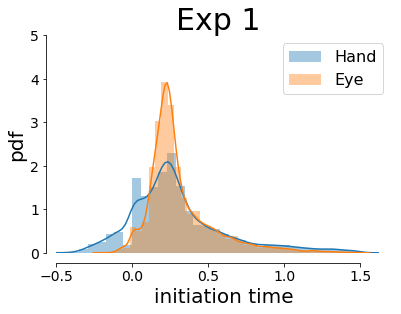

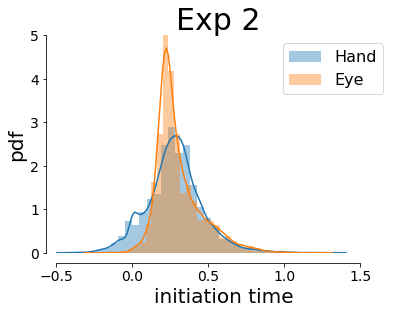

In [3]:
def plot_IT_dist(choices, exp):
    plt.figure()
    ax = sns.distplot(choices['hand IT'], bins=40, label='Hand')
    sns.distplot(choices.loc[~choices['eye IT'].isnull(), 'eye IT'], bins=40, label='Eye', ax=ax)
    ax.set_xlabel('initiation time')
    ax.set_ylabel('pdf')
    ax.set_xlim(-0.5, 1.7)
    ax.set_ylim(0, 5)
    sns.despine(ax=ax, trim=True, offset=10)
    plt.suptitle(exp, fontsize=30)
    plt.legend()
    plt.savefig('figures/IT_dist_%s' % (exp), bbox_inches='tight')

plot_IT_dist(choices_1, exp_1)
plot_IT_dist(choices_2, exp_2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


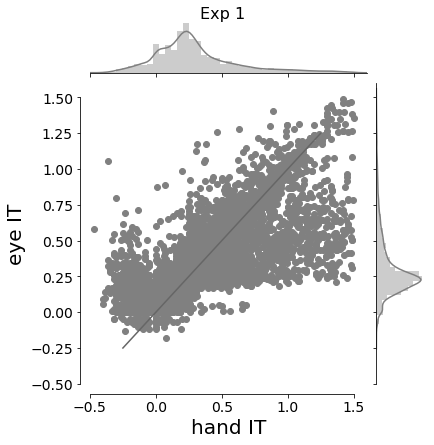

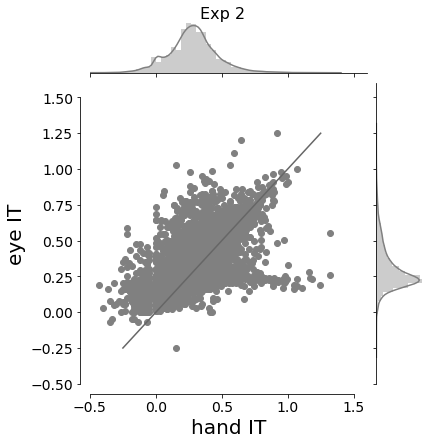

In [4]:
def plot_joint(choices, exp, x, y, stat_func=None):
    g = sns.jointplot(data=choices, x=x, y=y, stat_func=stat_func, color='0.5',
                      marginal_kws=dict(kde=True, hist=True), xlim=(-0.5,1.6), ylim=(-0.5,1.6))
    x_grid = np.linspace(-0.25, 1.25, 10)
    g.ax_joint.plot(x_grid,x_grid, color='0.4')
#     g.ax_joint.set_yticks(g.ax_joint.get_xticks())
    sns.despine(ax=g.ax_joint, trim=True, offset=10)
    plt.suptitle(exp, fontsize=16, y=1.0)
    g.savefig('figures/joint_%s_vs_%s_%s.png' % (x,y,exp)) 
    
plot_joint(choices_1, exp_1, x='hand IT', y='eye IT')
plot_joint(choices_2, exp_2, x='hand IT', y='eye IT')

Interestingly, ID lag is highly correlated with mouse IT but not with eye IT in Exp 1, so the lag is mainly determined by mouse response. However, in Exp 2, the lag depends on eye IT as well: correlation between the lag and mouse_IT is much weaker in Exp 2.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


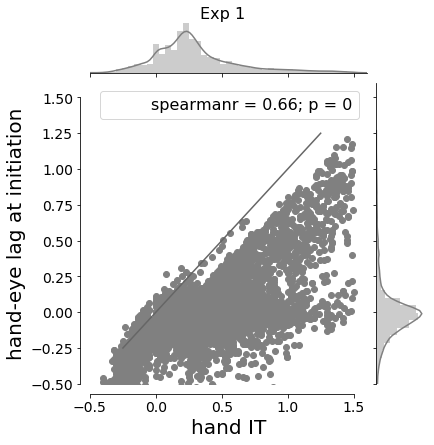

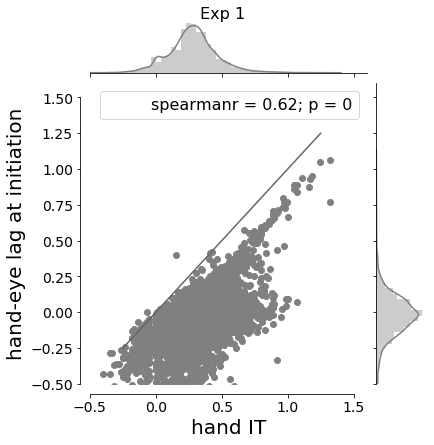

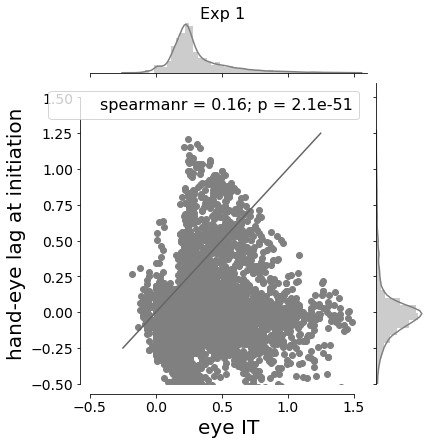

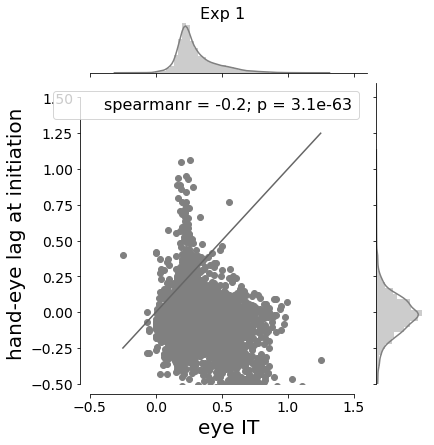

In [16]:
from scipy.stats import spearmanr

plot_joint(choices=choices_1[~(choices_1['eye IT'].isnull())], exp=exp_1, 
           x='hand IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_2[~(choices_2['eye IT'].isnull())], exp=exp_1, 
           x='hand IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_1[~(choices_1['eye IT'].isnull())], exp=exp_1, 
           x='eye IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_2[~(choices_2['eye IT'].isnull())], exp=exp_1, 
           x='eye IT', y='hand-eye lag at initiation', stat_func=spearmanr)

In Exp 1, dependence of ID lag on coherence basically follows that of mouse IT, with the green participant having substantially larger lag than the others due to late mouse movements.

Importing Jupyter notebook from initiation_times.ipynb


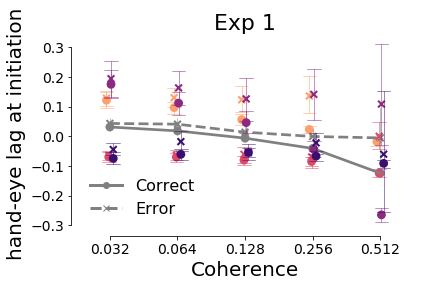

In [2]:
import nbimporter
from initiation_times import plot_var_vs_coherence

plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation', estimator=np.nanmean)

However, if we account for individual differences in scale of the lag, the general pattern becomes very clear

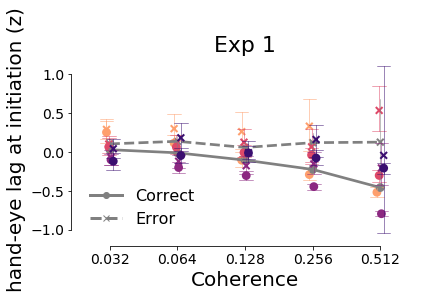

In [4]:
plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation (z)', estimator=np.nanmean)

Next, let's look at Exp 2 ID lag.

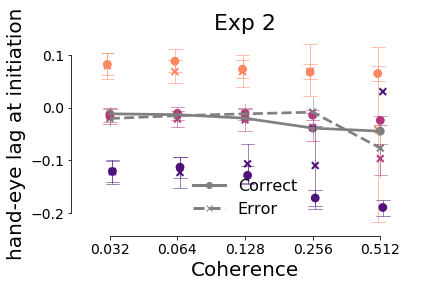

In [5]:
plot_var_vs_coherence(choices_2, exp_2, var='hand-eye lag at initiation', estimator=np.nanmean)

Here the variability is even higher. The three participants have very different lags, one has positive lag, one has negative lag, and another one's lag is around 0. It doesn't become clearer when z-scores are used.

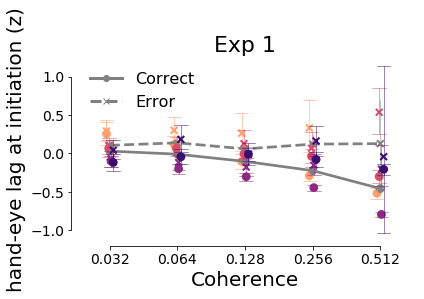

In [6]:
plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation (z)', estimator=np.nanmean)

# Eye-hand lags

First, let's take a look at hand-eye lag at initial decision

In [15]:
choices_2.loc[~np.isnan(choices_2['hand-eye lag at initiation']), 'hand-eye lag at initiation'].describe()

count   6,959.000
mean       -0.024
std         0.162
min        -0.879
25%        -0.111
50%        -0.020
75%         0.070
max         1.061
Name: hand-eye lag at initiation, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ID hand-eye lag in Exp 1: -0.011s, Exp. 2: -0.024s
ID lag diff from 0, Exp. 1 p-value: 0.00000, Exp. 2: 0.00000


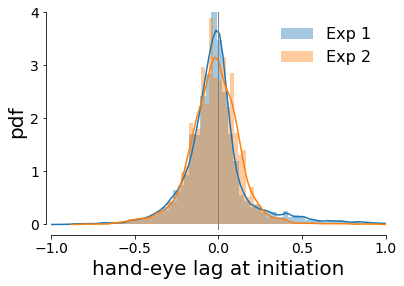

In [24]:
from scipy.stats import ttest_1samp

def ID_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.loc[(choices['hand-eye lag at initiation'].notnull()), 'hand-eye lag at initiation'], 0)
    return (t, p)

def plot_ID_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1['hand-eye lag at initiation']), 'hand-eye lag at initiation'], 
                      label='Exp 1', bins=80, kde=True, kde_kws={'cut': 0})    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2['hand-eye lag at initiation']), 'hand-eye lag at initiation'],
                      label='Exp 2', bins=80, kde=True, kde_kws={'cut': 0}, ax=ax)
    ax.set_xlim((-1.,1.))
    ax.set_ylim((-0.1,4))
    ax.set_xlabel('hand-eye lag at initiation')
    ax.set_ylabel('pdf') 
    plt.axvline(0.0, lw=1.0, color='gray')
    plt.legend(frameon=False)
    sns.despine(ax=ax, trim=True, offset=5)
    plt.savefig('figures/ID_lag', bbox_inches='tight')

plot_ID_lag_dist(choices_1, choices_2)
print('ID hand-eye lag in Exp 1: %.3fs, Exp. 2: %.3fs' % (choices_1['hand-eye lag at initiation'].mean(), 
                                                       choices_2['hand-eye lag at initiation'].mean()))
print('ID lag diff from 0, Exp. 1 p-value: %.5f, Exp. 2: %.5f' % (ID_lag_ttest_one_sample(choices_1)[1], 
                                                      ID_lag_ttest_one_sample(choices_2)[1]))

Now, here is the same lag at CoM decision

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CoM hand-eye lag in Exp 1: -0.057s, Exp. 2: -0.046s
CoM lag diff from 0, Exp. 1 p-value: 0.00006, Exp. 2: 0.00000


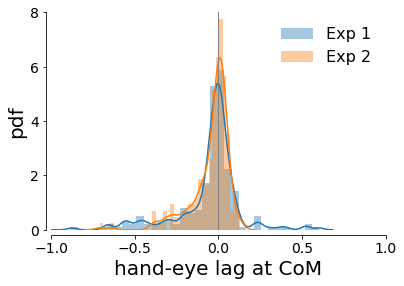

In [25]:
def com_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.com_lag[(choices.com_lag.notnull())], 0)
    return (t, p)

def plot_com_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1.com_lag), 'com_lag'], label='Exp 1', bins=40)    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2.com_lag), 'com_lag'], label='Exp 2', bins=40, ax=ax)
    ax.set_xlim((-1,1))
    ax.set_ylim((0,8))
    plt.axvline(0.0, lw=1.0, color='gray')
    ax.set_xlabel('hand-eye lag at CoM')
    ax.set_ylabel('pdf')    
    plt.legend(frameon=False)
    sns.despine(ax=ax, trim=True, offset=5)
    plt.savefig('figures/com_lag', bbox_inches='tight')

plot_com_lag_dist(choices_1, choices_2)
print('CoM hand-eye lag in Exp 1: %.3fs, Exp. 2: %.3fs' % (choices_1.com_lag.mean(), 
                                                       choices_2.com_lag.mean()))
print('CoM lag diff from 0, Exp. 1 p-value: %.5f, Exp. 2: %.5f' % (com_lag_ttest_one_sample(choices_1)[1], 
                                                      com_lag_ttest_one_sample(choices_2)[1]))


We can also look at the lags separately for early and late changes-of-mind:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


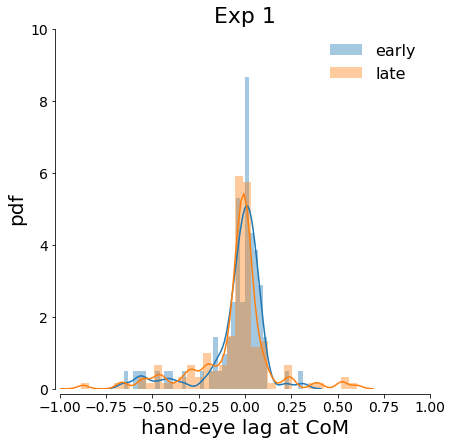

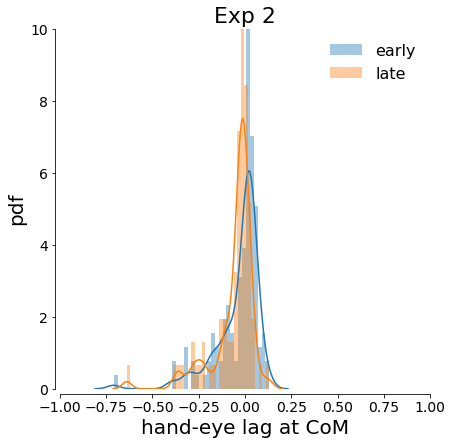

In [28]:
def plot_com_lag_dist_by_midline_d_y(choices, exp):    
#     choices['com_type'] = pd.cut(choices.midline_d_y, bins=[0, 700, 1080], labels=['early', 'late'])
    g = sns.FacetGrid(choices, hue='com_type', size=6, hue_order=['early', 'late'], xlim=(-1,1), ylim=(0,10))
    g = g.map(sns.distplot, 'com_lag', bins=40)
    g.set_axis_labels('hand-eye lag at CoM', 'pdf')
    plt.legend(frameon=False)
    g.despine(trim=True, offset=5)
    plt.title(exp)
    plt.savefig('figures/com_lag_by_com_type_%s' % (exp), bbox_inches='tight')

plot_com_lag_dist_by_midline_d_y(choices_1[choices_1.is_com], exp_1)
plot_com_lag_dist_by_midline_d_y(choices_2[choices_2.is_com], exp_2)

It seems that in late CoMs, the eye lags behind the hand more than in early CoMs. The difference is not statistically significant though.

In [30]:
from scipy.stats import ttest_ind

def pooled_sd(s1, s2):
    return np.sqrt(((len(s1)-1)*s1.var()+(len(s2)-1)*s2.var())/(len(s1)+len(s2)-2))

def com_lag_late_early_ttest(choices):
    t, p = ttest_ind(choices.loc[((choices.is_com) & (choices.com_type=='early') & (~choices.com_lag.isnull())), 'com_lag'], 
                    choices.loc[((choices.is_com) & (choices.com_type=='late') & (~choices.com_lag.isnull())), 'com_lag'], equal_var=False)
    return (t, p)

print('Exp 1, p-value: %f' % (com_lag_late_early_ttest(choices_1)[1]))
print('Exp 2, p-value: %f' % (com_lag_late_early_ttest(choices_2)[1]))


Exp 1, p-value: 0.548279
Exp 2, p-value: 0.159783
